In [24]:
import sys
import os

# Get the parent directory of current directory
parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(parent_dir)

# Now you can import from pyScripts
from oldmarch.cluster_g_logit_init_acceptpsi import *

%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:

%autoreload 2
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

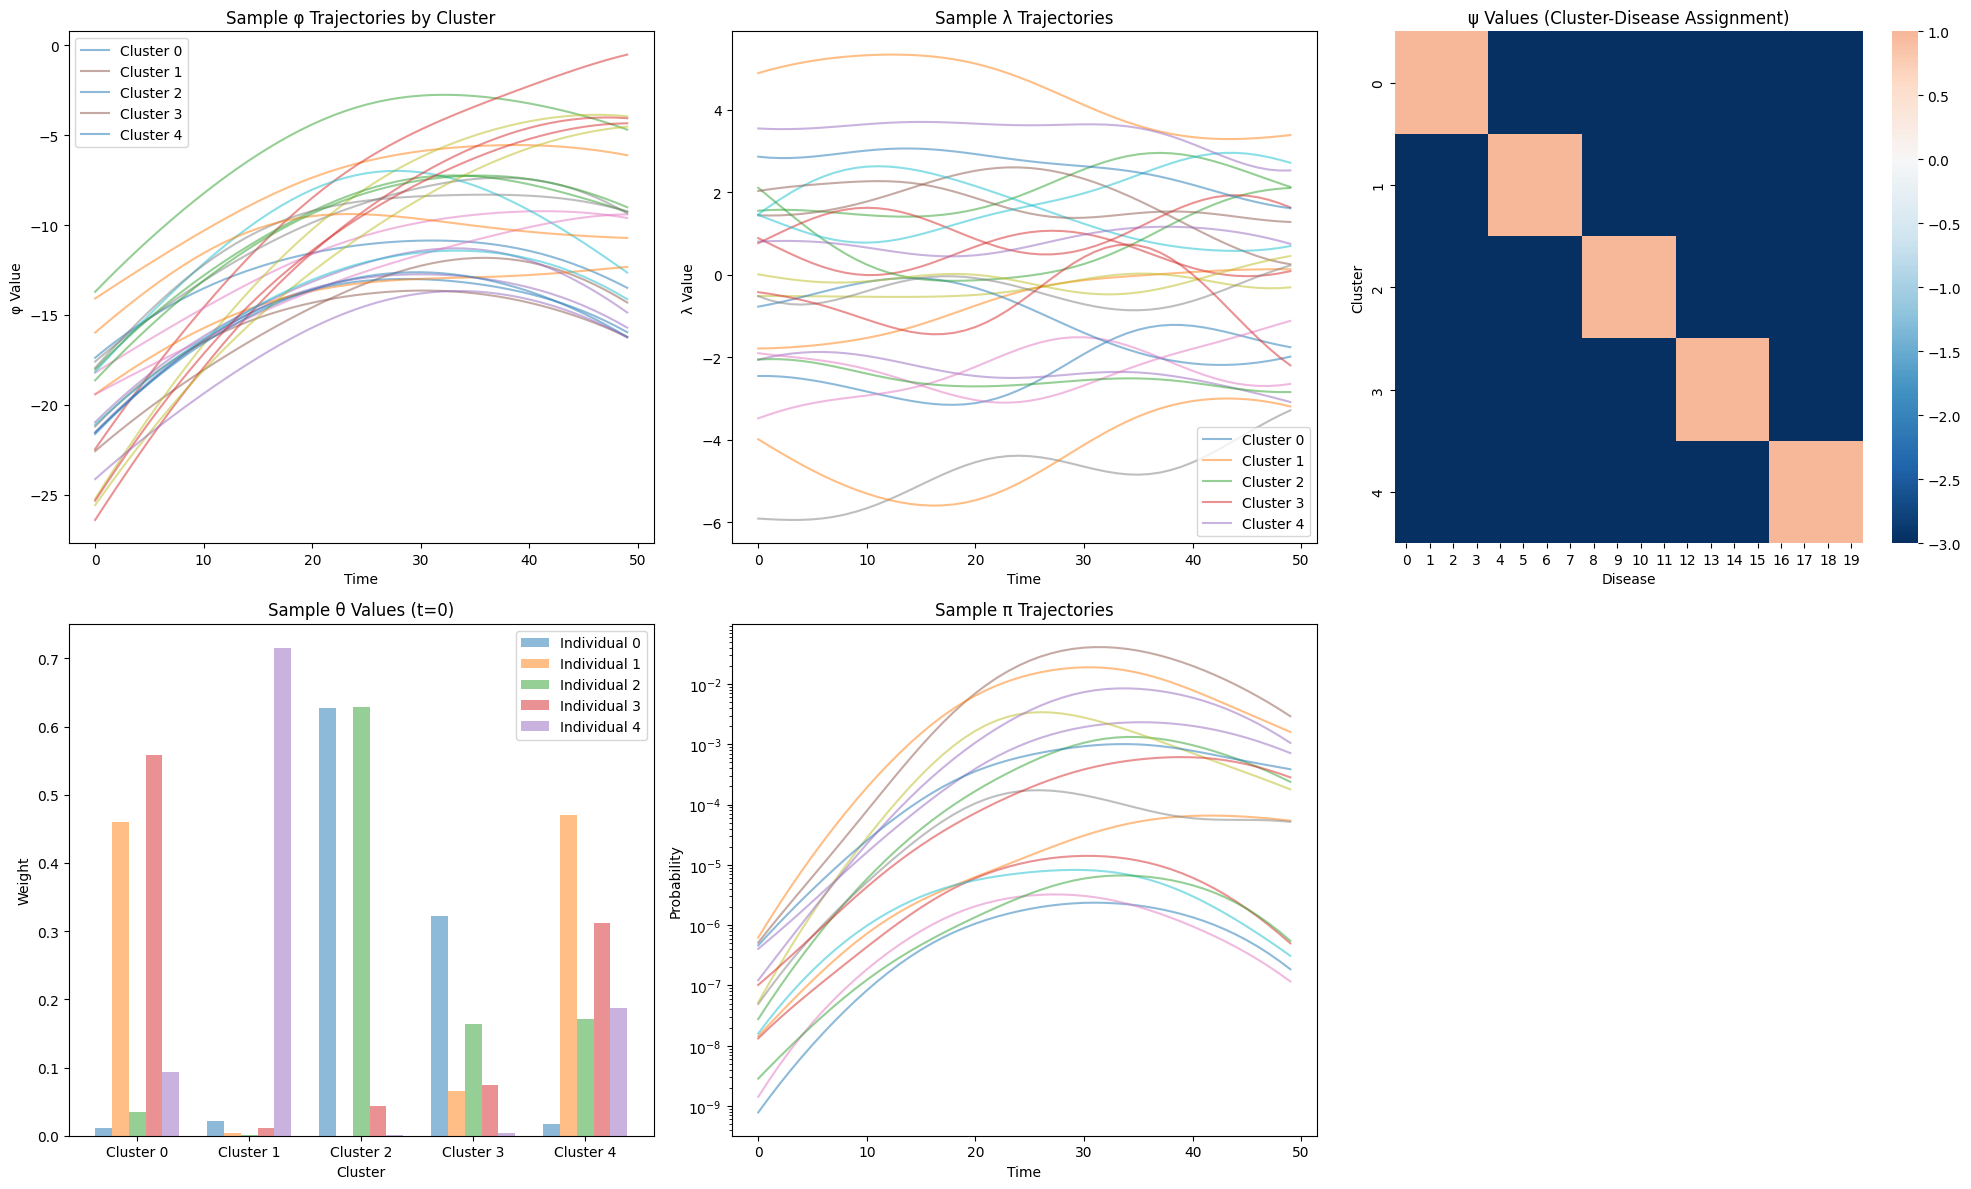

In [26]:
# Generate and plot
np.random.seed(42)
data = generate_clustered_survival_data(N=10000, D=20, T=50, K=5, P=5)
plot_synthetic_components(data)

In [5]:
Y_tensor = torch.tensor(data['Y'], dtype=torch.float32)
Y_avg = torch.mean(Y_tensor, dim=2)
Y_corr = torch.corrcoef(Y_avg.T)
Y_avg


tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0200, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0200,  ..., 0.0200, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0200, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0200,  ..., 0.0200, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0200, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0200,  ..., 0.0200, 0.0000, 0.0000]])

In [6]:

K=5
similarity = (Y_corr + 1) / 2
spectral = SpectralClustering(
            n_clusters=K,  # One less for background state
            assign_labels='kmeans',
            affinity='precomputed',
            n_init=10,
            random_state=42
        ).fit(similarity.numpy())
        
clusters = spectral.labels_

In [7]:
print("Number of events per disease:")
print(data['Y'].sum(axis=(0,2)))  # Sum over individuals and time
print(data['Y'].mean(axis=(0,2)))  # Sum over individuals and time

print("\nNumber of events per time point:")
print(data['Y'].sum(axis=(0,1)))  # Sum over individuals and diseases

Number of events per disease:
[1.000e+00 1.300e+02 1.355e+03 3.637e+03 2.800e+01 7.646e+03 4.710e+02
 1.000e+04 3.637e+03 6.663e+03 8.242e+03 2.370e+02 9.986e+03 1.247e+03
 8.220e+02 9.059e+03 9.957e+03 9.801e+03 6.000e+00 2.830e+02]
[2.0000e-06 2.6000e-04 2.7100e-03 7.2740e-03 5.6000e-05 1.5292e-02
 9.4200e-04 2.0000e-02 7.2740e-03 1.3326e-02 1.6484e-02 4.7400e-04
 1.9972e-02 2.4940e-03 1.6440e-03 1.8118e-02 1.9914e-02 1.9602e-02
 1.2000e-05 5.6600e-04]

Number of events per time point:
[  12.   22.   27.   57.  103.  145.  236.  303.  413.  486.  540.  611.
  623.  695.  701.  736.  821.  922. 1043. 1090. 1178. 1237. 1245. 1252.
 1235. 1282. 1378. 1541. 1748. 2033. 2208. 2551. 2865. 2939. 3117. 3191.
 3224. 3270. 3361. 3302. 3448. 3398. 3492. 3229. 3095. 3024. 2774. 2574.
 2284. 2147.]


In [8]:
# First generate synthetic data
np.random.seed(42)

# Convert data to tensors for the model
Y_tensor = torch.tensor(data['Y'], dtype=torch.float32)
G_tensor = torch.tensor(data['G'], dtype=torch.float32)
E_tensor = torch.tensor(data['event_times'], dtype=torch.float32)
true_psi = torch.tensor(data['psi'], dtype=torch.float32)


In [9]:

# Calculate prevalence_t from synthetic data
prevalence_t = compute_smoothed_prevalence(Y_tensor)  # Average over individuals



/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_troubleshoot.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_troubleshoot.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_troubleshoot.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 3 diseases
Cluster 1: 8 diseases
Cluster 2: 4 diseases
Cluster 3: 3 diseases
Cluster 4: 2 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 3
Base value (first 5): tensor([ -7.1997, -10.5076, -10.5076, -10.5076,  -7.1997])
Base value centered (first 5): tensor([ 0.6275, -2.6804, -2.6804, -2.6804,  0.6275])
Base value centered mean: 3.0059814548621944e-07
Gamma init for k=0 (first 5): tensor([ 0.2781,  0.2558, -0.2568, -0.2966,  0.1783])

Calculating gamma for k=1:
Number of diseases in cluster: 8
Base value (first 5): tensor([-10.0941, -10.0941, -10.0941, -10.0941, -10.0941])
Base value centered (first 5): tensor([-0.0388, -0.0388, -0.0388, -0.0388, -0.0388])
Base value centered mean: 4.2476654016354587e-07
Gamma init for k=1 (first 5): tensor([ 0.0050, -0.0058,  0.0114,  0.0317, -0.0129])

Calculating gamma for k=2:
Number of diseases in cluster: 4
Base value (first 5): tensor([ -3.8918, -11.3346,  -3.8918,  -6.3727,  -8.8537])
Base value c

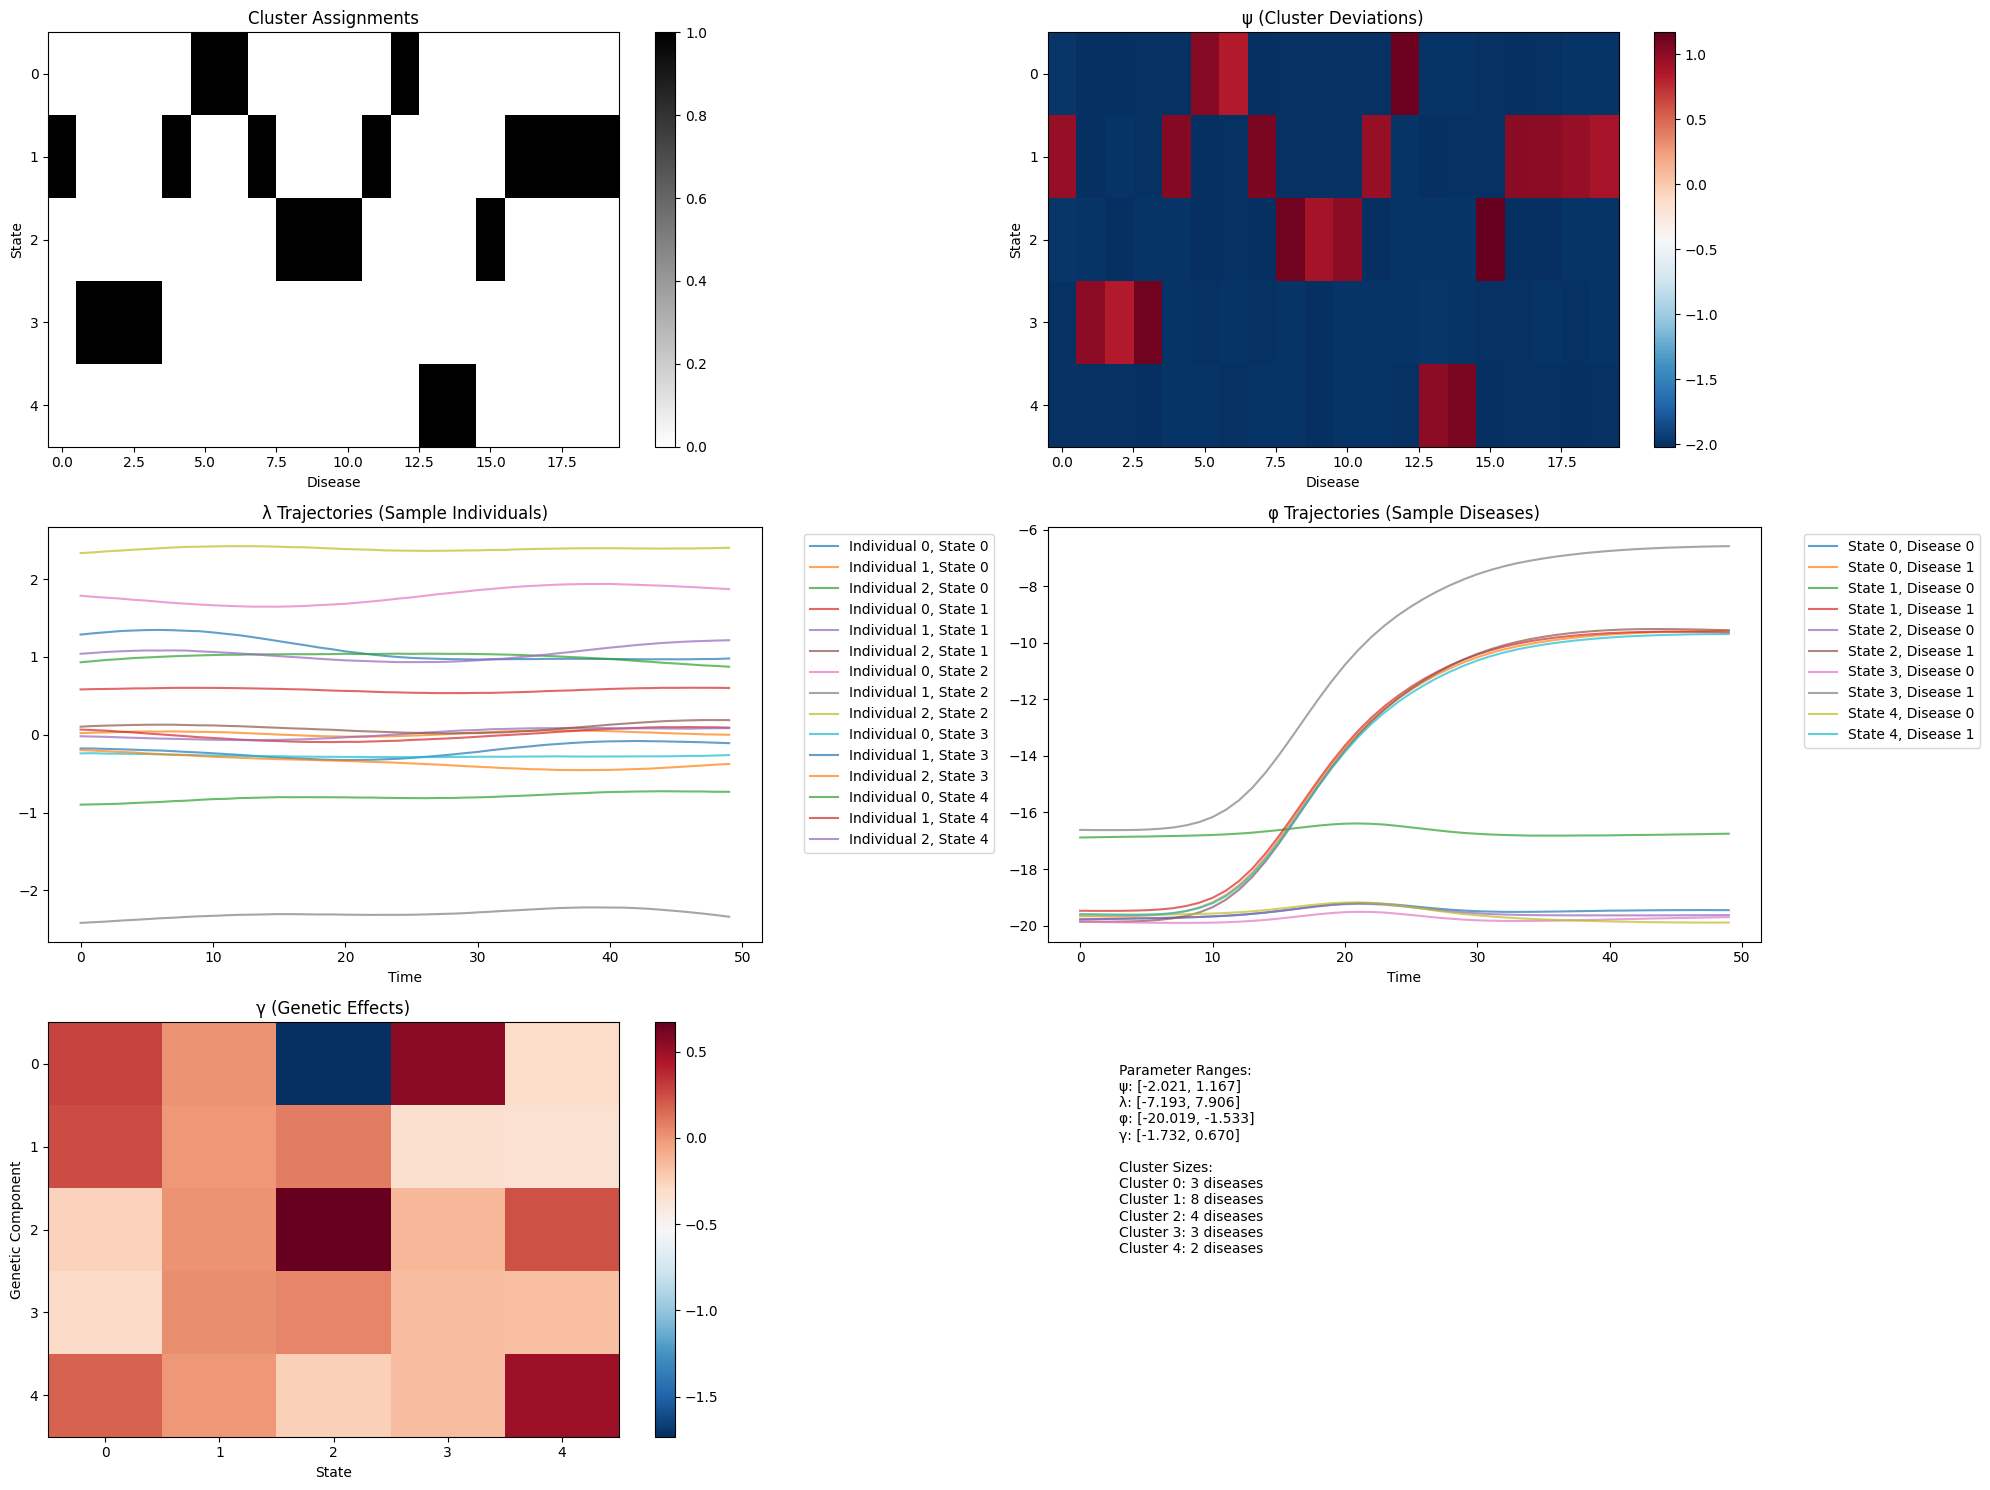

In [20]:
model_est = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,
    R=0,                     # Make sure R is provided
    W=1e-4,                # Make sure W is provided
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1,     # This matches your class definition
    genetic_scale=1,
    signature_references=None,
    healthy_reference=None,
    disease_names=None,
    flat_lambda=True,
    learn_kappa=True
)

model_est.visualize_initialization()



Clustering Metrics:
Adjusted Rand Index: 0.294
Normalized Mutual Information: 0.592


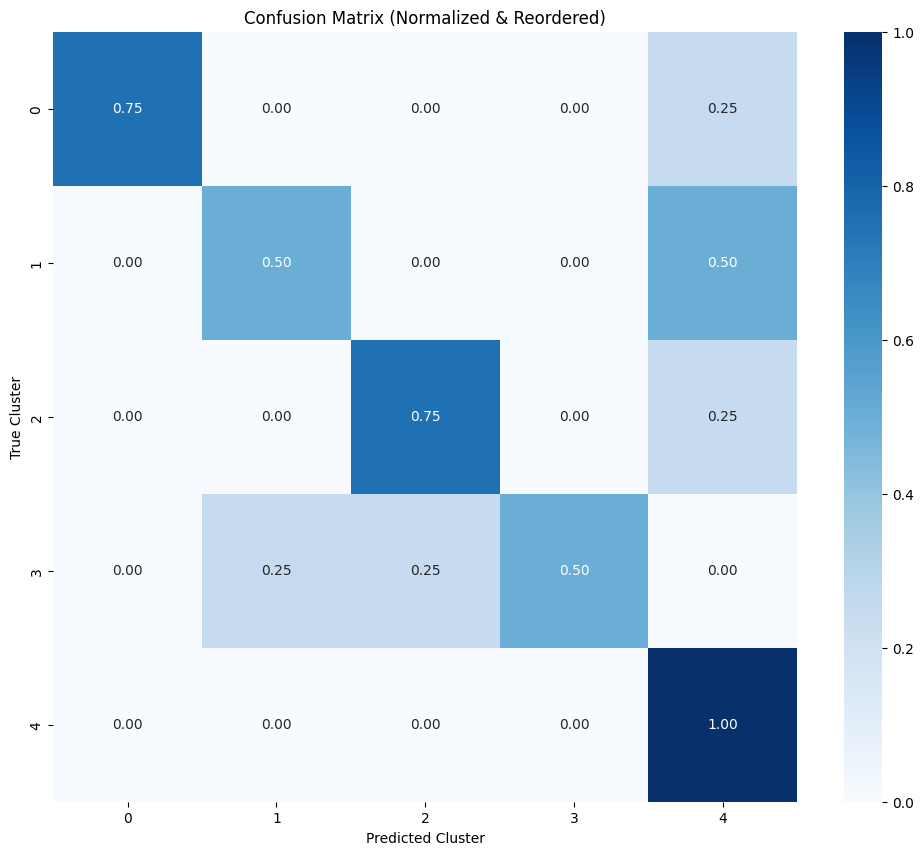

array([3, 0, 2, 4, 1])

In [27]:
from analyze_clusters import *
plot_confusion_matrix(data['clusters'], model_est.clusters, K=5) 

In [ ]:
from clust_huge_amp import *

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 3 diseases
Cluster 1: 8 diseases
Cluster 2: 4 diseases
Cluster 3: 3 diseases
Cluster 4: 2 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 3
Base value (first 5): tensor([ -7.1997, -10.5076, -10.5076, -10.5076,  -7.1997])
Base value centered (first 5): tensor([ 0.6275, -2.6804, -2.6804, -2.6804,  0.6275])
Base value centered mean: 3.0059814548621944e-07
Gamma init for k=0 (first 5): tensor([ 0.2781,  0.2558, -0.2568, -0.2966,  0.1783])

Calculating gamma for k=1:
Number of diseases in cluster: 8
Base value (first 5): tensor([-10.0941, -10.0941, -10.0941, -10.0941, -10.0941])
Base value centered (first 5): tensor([-0.0388, -0.0388, -0.0388, -0.0388, -0.0388])
Base value centered mean: 4.2476654016354587e-07
Gamma init for k=1 (first 5): tensor([ 0.0050, -0.0058,  0.0114,  0.0317, -0.0129])

Calculating gamma for k=2:
Number of diseases in cluster: 4
Base value (first 5): tensor([ -3.8918, -11.3346,  -3.8918,  -6.3727,  -8.8537])
Base value c

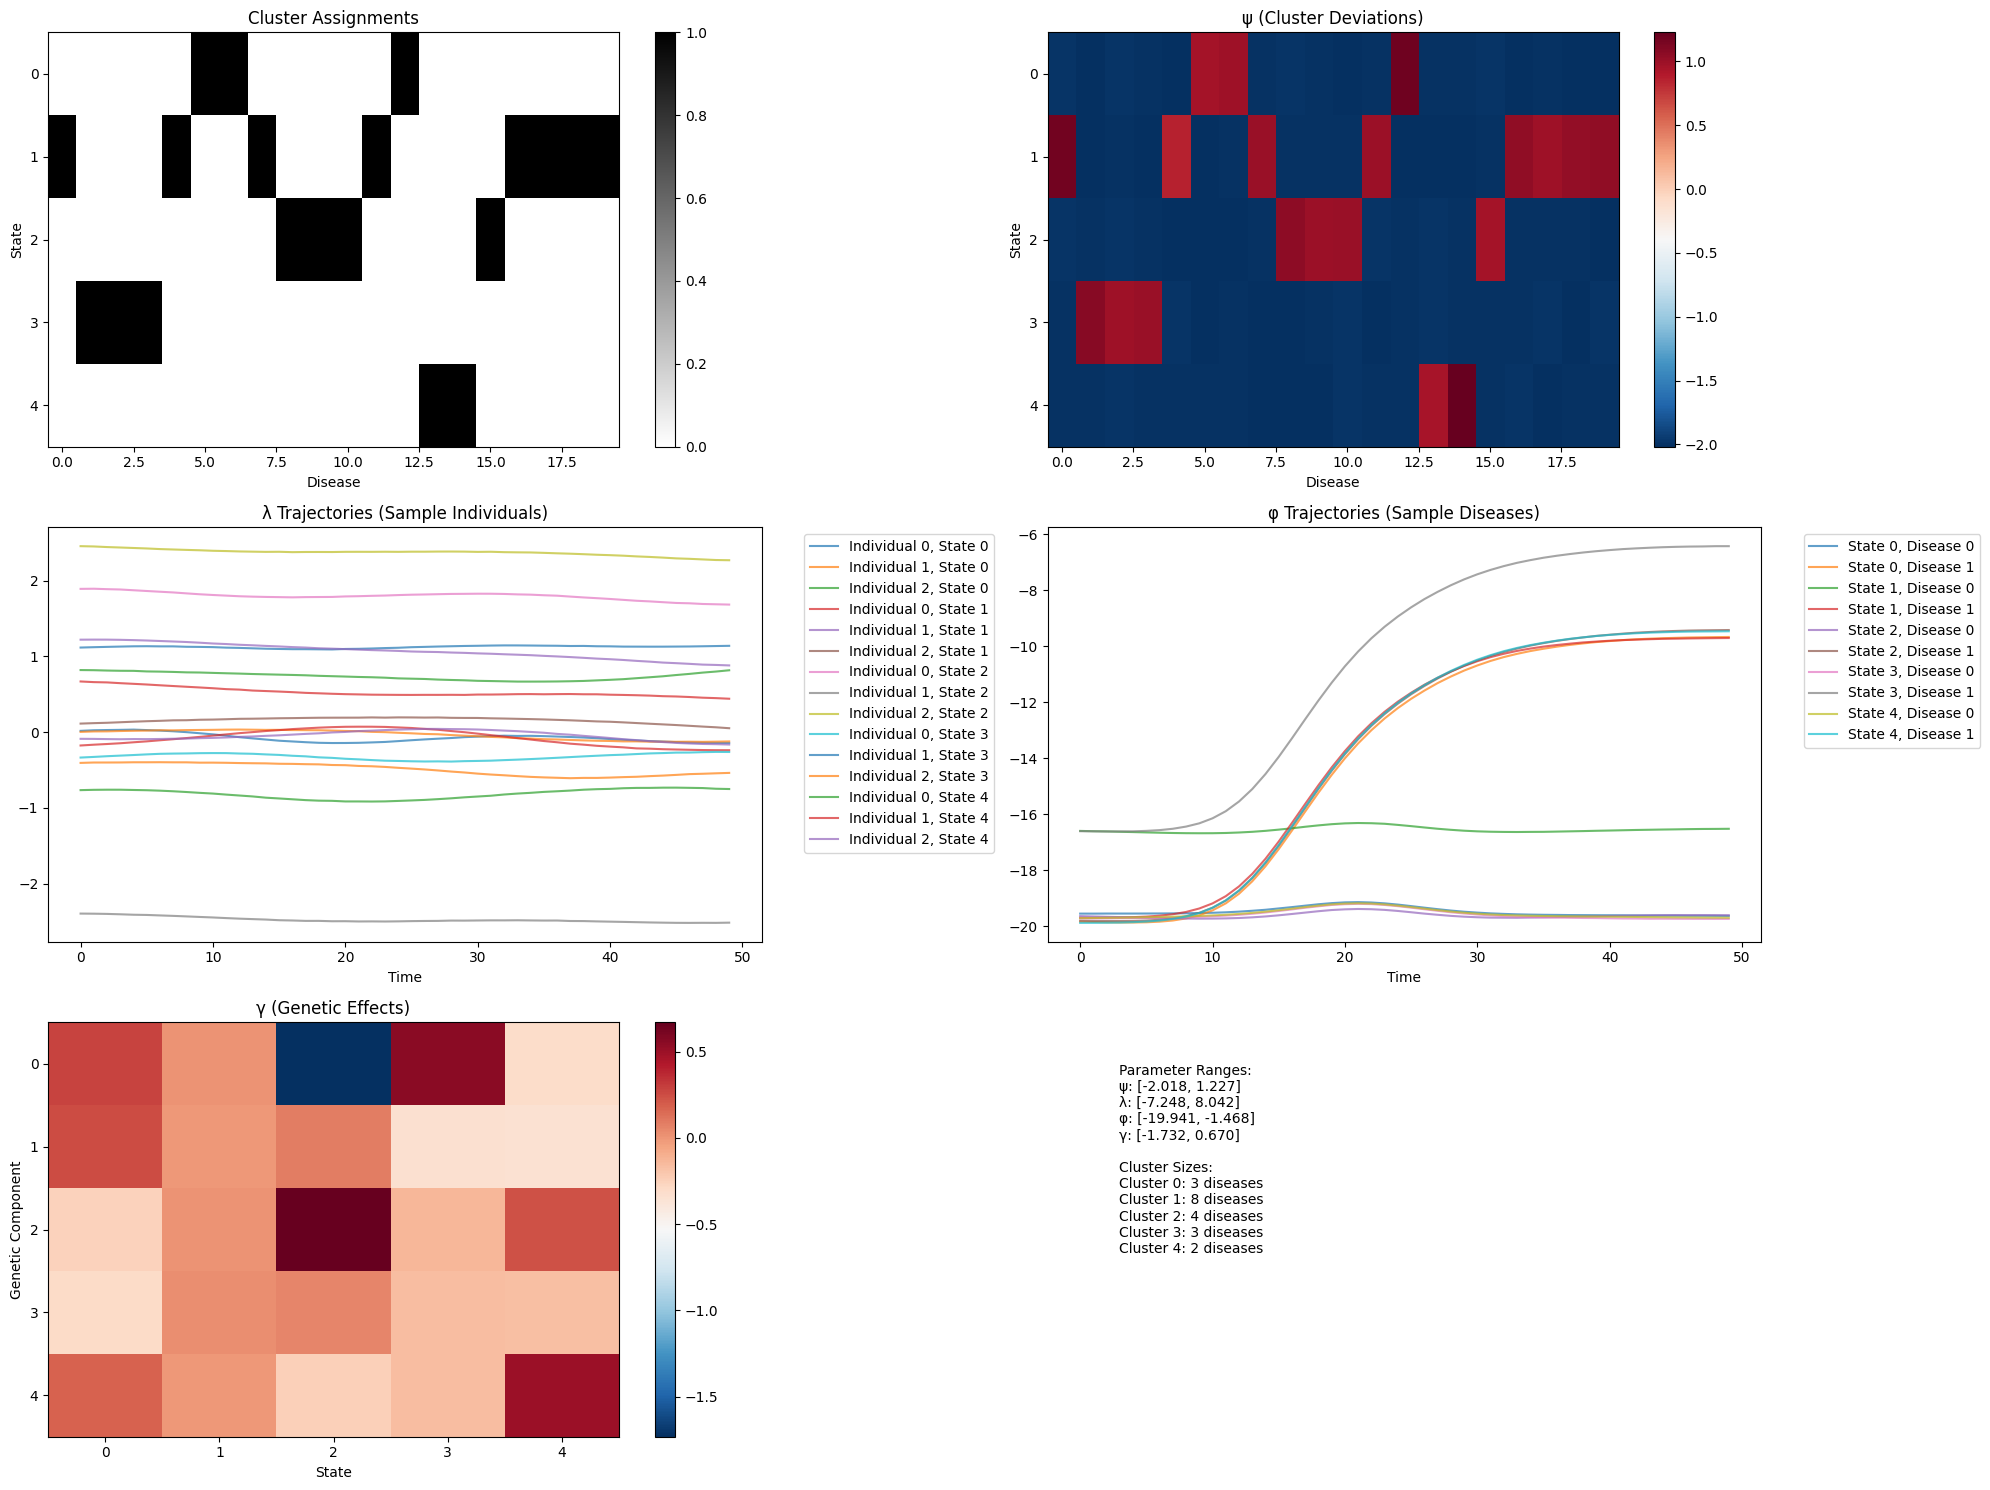

In [92]:
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,
    R=0,                     # Make sure R is provided
    W=1e-4,                # Make sure W is provided
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1,     # This matches your class definition
    genetic_scale=1,
    signature_references=None,
    healthy_reference=None,
    disease_names=None,
    flat_lambda=True,
    learn_kappa=True
)

model.visualize_initialization()



Calculating gamma for k=0:
Number of diseases in cluster: 4.0
Base value (first 5): tensor([-13.8155,  -8.8537, -13.8155, -11.3346, -13.8155])
Base value centered (first 5): tensor([-1.2710,  3.6909, -1.2710,  1.2099, -1.2710])
Base value centered mean: -3.94248957036325e-07
Gamma init for k=0 (first 5): tensor([ 0.4125, -0.2524, -0.0999, -0.1241, -0.1186])

Calculating gamma for k=1:
Number of diseases in cluster: 4.0
Base value (first 5): tensor([ -8.8537, -11.3346, -11.3346, -11.3346,  -8.8537])
Base value centered (first 5): tensor([ 0.4602, -2.0207, -2.0207, -2.0207,  0.4602])
Base value centered mean: 1.745605459291255e-06
Gamma init for k=1 (first 5): tensor([ 0.2134,  0.1943, -0.1943, -0.2261,  0.1326])

Calculating gamma for k=2:
Number of diseases in cluster: 4.0
Base value (first 5): tensor([ -6.3727, -11.3346,  -6.3727,  -8.8537, -11.3346])
Base value centered (first 5): tensor([ 2.7838, -2.1780,  2.7838,  0.3029, -2.1780])
Base value centered mean: 2.479553273815327e-08
G

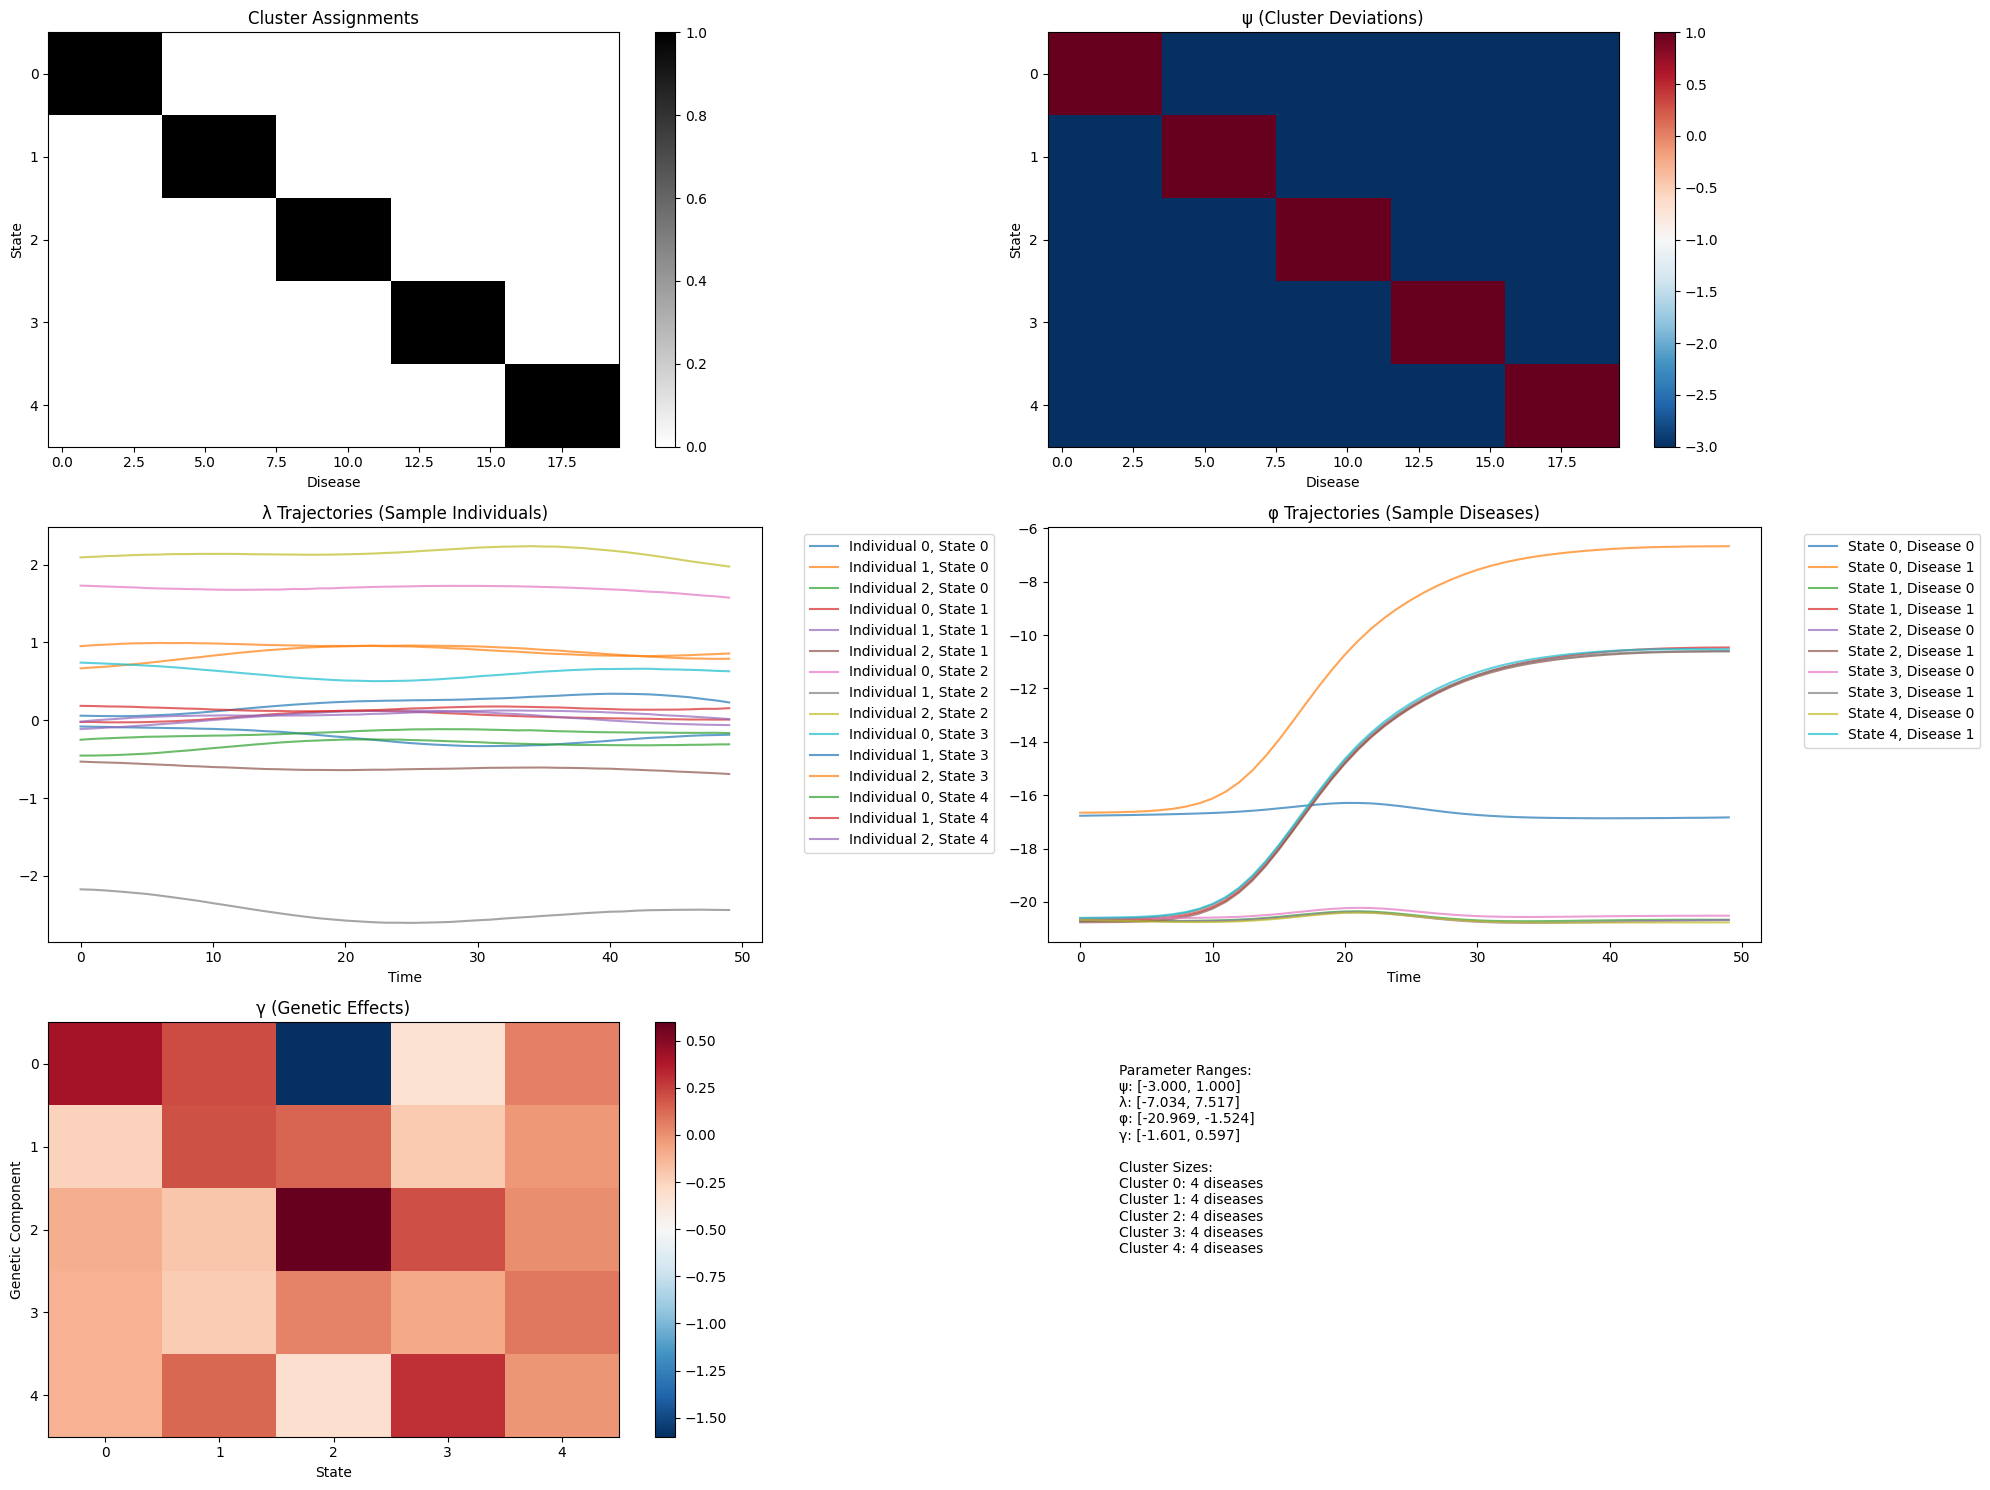

In [93]:

# Initialize with true psi
model.initialize_params(true_psi=true_psi)
model.clusters = data['clusters'] 

model.visualize_initialization()

In [94]:

K=5
# Store initial psi values
initial_psi = model.psi.detach().clone()

import cProfile
import pstats
from pstats import SortKey

# For the healthtoo version
profiler = cProfile.Profile()
profiler.enable()
history_new = model.fit(E_tensor, num_epochs=100, learning_rate=1e-1, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 38.7014

Monitoring signature responses:

Disease 13 (signature 3, LR=59.94):
  Theta for diagnosed: 0.215 ± 0.091
  Theta for others: 0.160
  Proportion difference: 0.055

Disease 11 (signature 2, LR=56.97):
  Theta for diagnosed: 0.507 ± 0.276
  Theta for others: 0.276
  Proportion difference: 0.231

Disease 14 (signature 3, LR=56.12):
  Theta for diagnosed: 0.230 ± 0.089
  Theta for others: 0.161
  Proportion difference: 0.068

Disease 2 (signature 0, LR=55.77):
  Theta for diagnosed: 0.282 ± 0.127
  Theta for others: 0.185
  Proportion difference: 0.097

Disease 6 (signature 1, LR=55.62):
  Theta for diagnosed: 0.278 ± 0.115
  Theta for others: 0.183
  Proportion difference: 0.095

Epoch 1
Loss: 176.0525

Monitoring signature responses:

Disease 13 (signature 3, LR=59.94):
  Theta for diagnosed: 0.215 ± 0.090
  Theta for others: 0.160
  Proportion difference: 0.054

Disease 11 (signature 2, LR=56.99):
  Theta for diagnosed: 0.507 ± 0.276
  Theta for others: 0.276
  P

In [12]:
history_new[0]
    

[38.63582229614258,
 176.13821411132812,
 50.812557220458984,
 69.92330932617188,
 111.55606842041016,
 91.73709106445312,
 54.889869689941406,
 41.474727630615234,
 54.67424774169922,
 69.19413757324219,
 66.26589965820312,
 51.14424514770508,
 39.058494567871094,
 38.67334747314453,
 46.234657287597656,
 51.495361328125,
 48.815330505371094,
 41.28468322753906,
 35.70551300048828,
 35.77769088745117,
 39.432273864746094,
 41.782466888427734,
 40.247432708740234,
 36.47275161743164,
 33.893463134765625,
 34.191383361816406,
 36.02638244628906,
 36.860599517822266,
 35.6634635925293,
 33.637168884277344,
 32.61112594604492,
 33.11404037475586,
 34.06031036376953,
 34.1308479309082,
 33.172210693359375,
 32.14382553100586,
 31.919557571411133,
 32.382198333740234,
 32.7180061340332,
 32.415382385253906,
 31.766210556030273,
 31.39983558654785,
 31.525169372558594,
 31.76951026916504,
 31.702526092529297,
 31.338520050048828,
 31.039926528930664,
 31.033063888549805,
 31.165184020996094,

In [16]:
model.kappa

Parameter containing:
tensor([4.1958], requires_grad=True)

In [20]:
def plot_training_evolution(history_tuple):
    losses, gradient_history = history_tuple
    
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Evolution')
    #plt.yscale('log')
    plt.legend()
    
    # Plot lambda gradients
    plt.subplot(1, 3, 2)
    lambda_norms = [torch.norm(g).item() for g in gradient_history['lambda_grad']]
    plt.plot(lambda_norms, label='Lambda gradients')
    #plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient norm')
    plt.title('Lambda Gradient Evolution')
    plt.legend()
    
    # Plot phi gradients
    plt.subplot(1, 3, 3)
    phi_norms = [torch.norm(g).item() for g in gradient_history['phi_grad']]
    plt.plot(phi_norms, label='Phi gradients')
    #plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient norm')
    plt.title('Phi Gradient Evolution')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

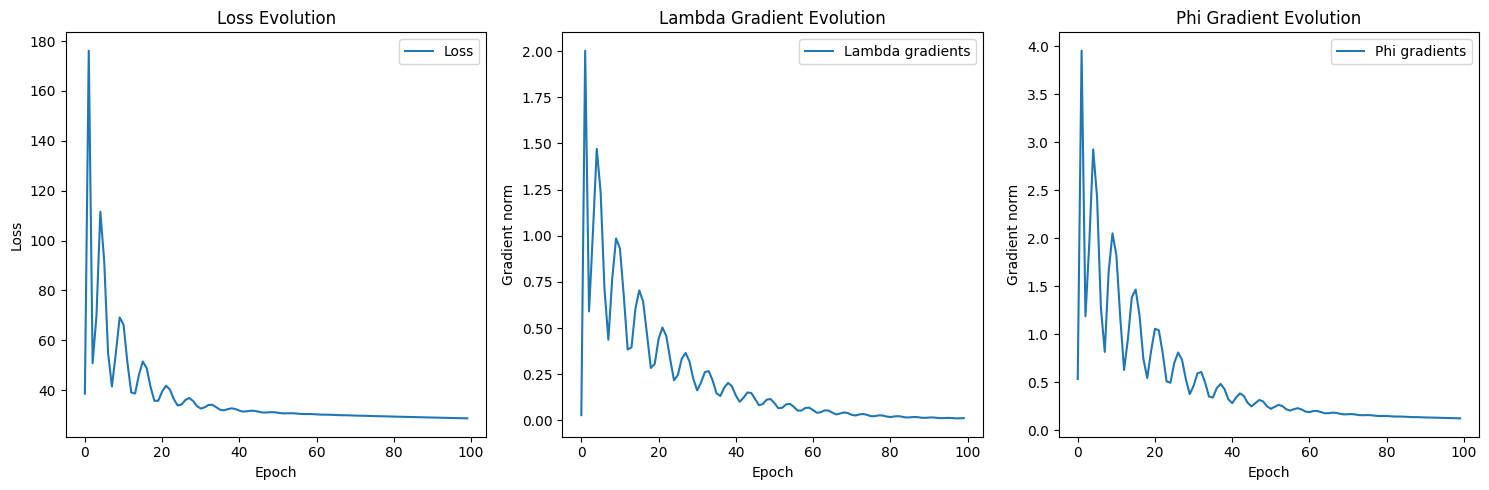

In [19]:
plot_training_evolution(history_new)

In [21]:
lambda_nans = [torch.isnan(g).any().item() for g in history_new[1]['lambda_grad']]
phi_nans = [torch.isnan(g).any().item() for g in history_new[1]['phi_grad']]

In [22]:
initial_psi


tensor([[ 1.,  1.,  1.,  1., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
         -3., -3., -3., -3., -3., -3.],
        [-3., -3., -3., -3.,  1.,  1.,  1.,  1., -3., -3., -3., -3., -3., -3.,
         -3., -3., -3., -3., -3., -3.],
        [-3., -3., -3., -3., -3., -3., -3., -3.,  1.,  1.,  1.,  1., -3., -3.,
         -3., -3., -3., -3., -3., -3.],
        [-3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,  1.,  1.,
          1.,  1., -3., -3., -3., -3.],
        [-3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
         -3., -3.,  1.,  1.,  1.,  1.]])

In [23]:
model.psi

Parameter containing:
tensor([[ 1.0621,  1.0751,  0.8009,  1.4103, -3.0648, -2.9520, -3.0208, -2.9674,
         -3.0257, -3.0445, -3.0684, -3.0090, -3.0914, -2.9968, -2.9928, -3.0935,
         -2.8607, -3.1615, -2.9801, -3.0713],
        [-2.9210, -2.9594, -2.8838, -3.1425,  0.9159,  1.3653,  1.3078,  0.5617,
         -3.1811, -3.1622, -3.1672, -3.0690, -3.1069, -2.8912, -3.0022, -3.0930,
         -3.0180, -3.2782, -2.9798, -3.0447],
        [-2.9274, -2.8918, -3.0591, -3.1193, -3.0934, -2.2691, -2.9651, -2.9410,
          0.3726,  0.9879,  0.9443,  1.1035, -3.2370, -3.0167, -3.0239, -2.8283,
         -3.0579, -3.3736, -2.9893, -3.0189],
        [-2.9575, -2.9287, -2.9540, -2.9958, -3.0398, -2.9226, -2.9469, -3.1654,
         -3.0736, -2.9856, -3.0813, -2.9491, -0.0371,  0.7413,  0.8884,  1.7195,
         -2.9547, -3.1023, -3.0983, -3.0128],
        [-2.9323, -3.0818, -2.9320, -2.9814, -3.0826, -3.0004, -2.9246, -3.1130,
         -3.0464, -3.0977, -3.0066, -3.0392, -3.0305, -3.1357, -3

In [24]:
model.kappa

Parameter containing:
tensor([4.1958], requires_grad=True)

In [25]:
# For plotting smoothed prevalences
def plot_smoothed_prevalences(model, data):
    # Data smoothed prevalence
    data_prev = data['Y'].mean(axis=0)  # Average across individuals
    
    # Model smoothed prevalence (using mu_d/logit_prev_t)
    model_prev = torch.sigmoid(model.logit_prev_t)  # Convert logits to probabilities
    
    plt.figure(figsize=(10, 6))
    
    # Plot for each disease
    for d in range(data_prev.shape[0]):
        plt.plot(data_prev[d], 'b-', alpha=0.3, label='Data' if d==0 else '')
        plt.plot(model_prev[:, d].detach().numpy(), 'r--', alpha=0.3, 
                label='Model' if d==0 else '')
    
    plt.xlabel('Time')
    plt.ylabel('Prevalence')
    plt.title('Smoothed Prevalences: Data vs Model')
    plt.legend()
    plt.yscale('log')  # Optional: use log scale if prevalences vary widely
    plt.grid(True)
    plt.show()

In [29]:
with torch.no_grad():
    pi_pred, theta, phi = model.forward()
    pi_pred = pi_pred.cpu().numpy()

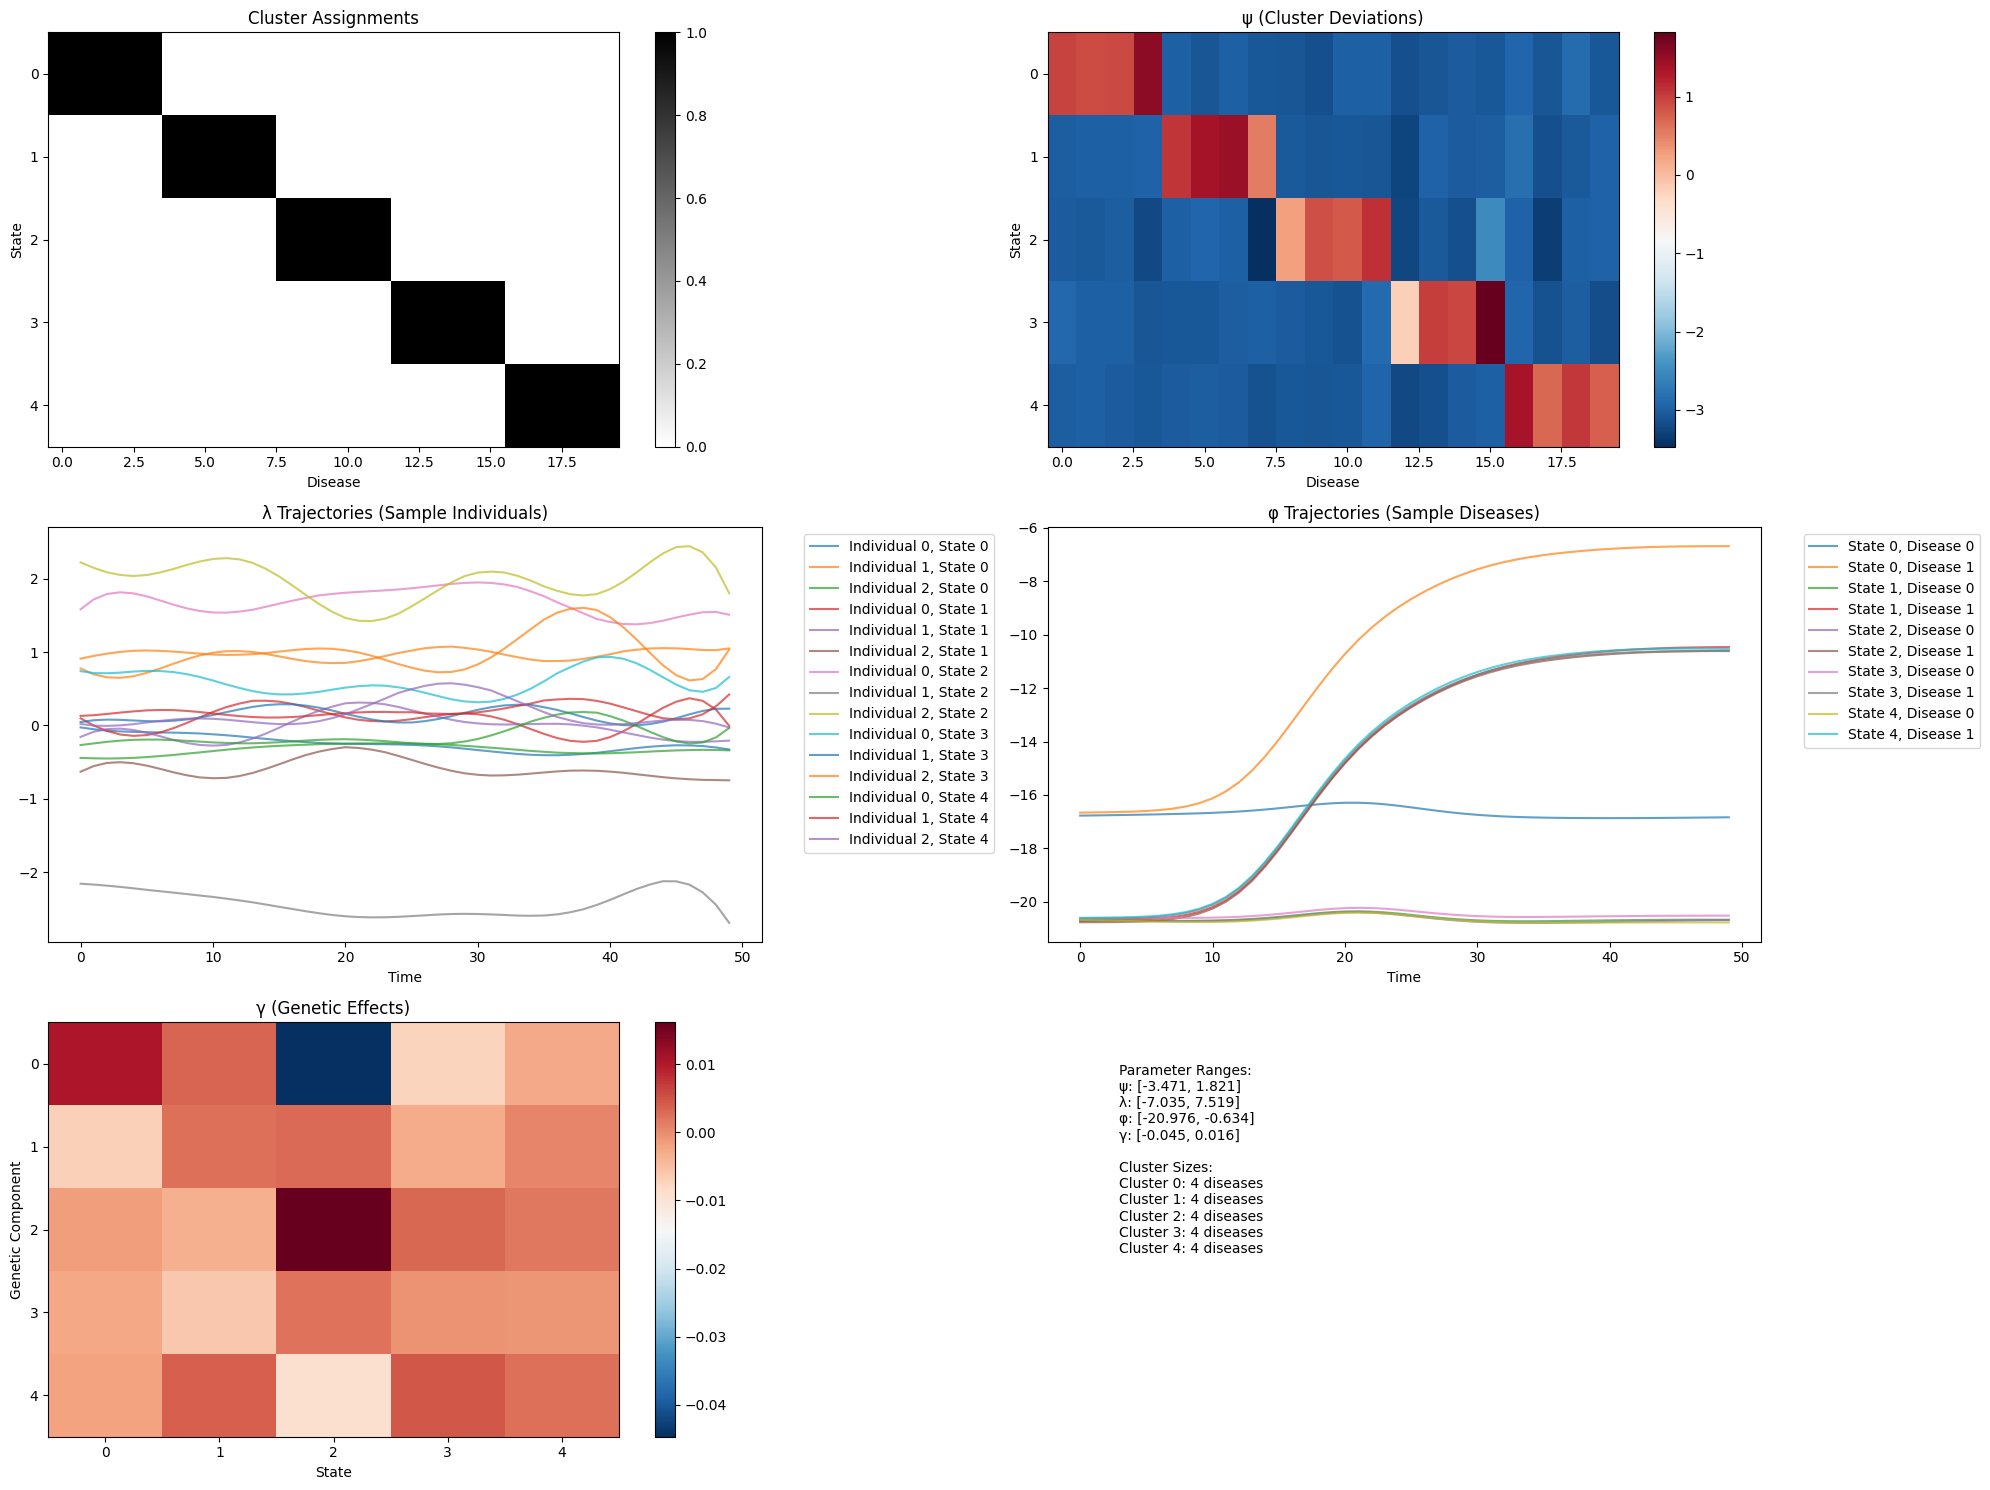

In [95]:
model.visualize_initialization()

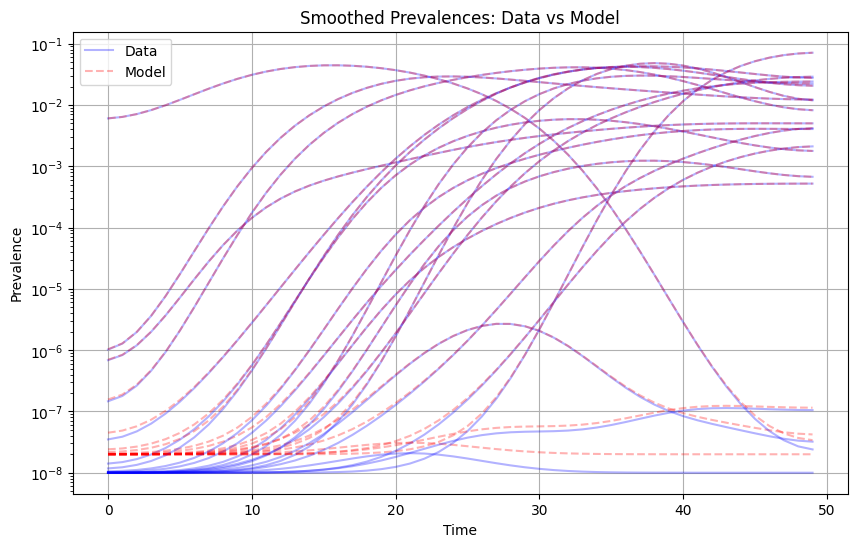

In [26]:
# For plotting smoothed prevalences
def plot_smoothed_prevalences(model, data):
    # Data smoothed prevalence
    data_prev = compute_smoothed_prevalence(data['Y'])  # Average across individuals
    
    # Model smoothed prevalence (using mu_d/logit_prev_t)
    model_prev = torch.sigmoid(model.logit_prev_t)  # Convert logits to probabilities
    
    plt.figure(figsize=(10, 6))
    
    # Plot for each disease
    for d in range(data_prev.shape[0]):
        plt.plot(data_prev[d], 'b-', alpha=0.3, label='Data' if d==0 else '')
        plt.plot(model_prev[d, :].detach().numpy(), 'r--', alpha=0.3, 
                label='Model' if d==0 else '')
    
    plt.xlabel('Time')
    plt.ylabel('Prevalence')
    plt.title('Smoothed Prevalences: Data vs Model')
    plt.legend()
    plt.yscale('log')  # Optional: use log scale if prevalences vary widely
    plt.grid(True)
    plt.show()

plot_smoothed_prevalences(model, data)

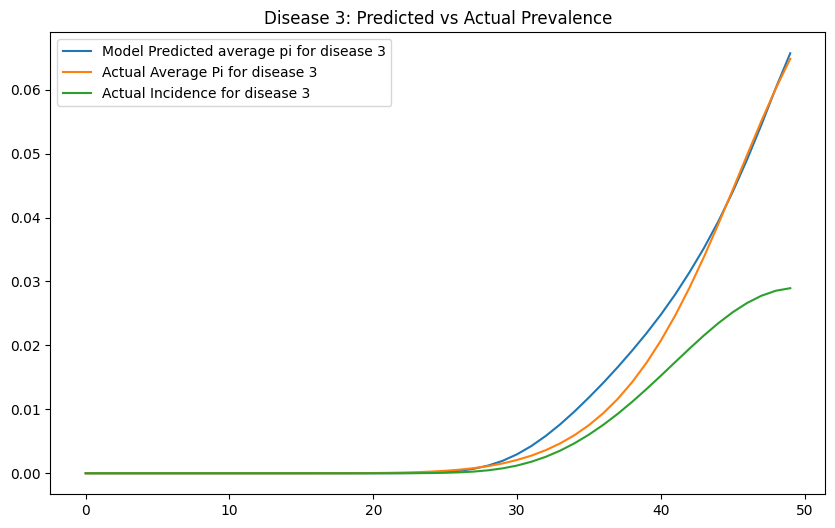

In [30]:
# Mean predicted probability for disease 3 over time
mean_pred_d3 = pi_pred[:, 3, :].mean(axis=0)  # Average across people

# Actual prevalence for disease 3 over time
real_prev_pi = data['pi'][:, 3, :].mean(axis=0)  # Average across people

#real_prev_d3 = data['Y'][:, 3, :].mean(axis=0)  # Average across people

real_prev_d3 = model.prevalence_t[3,:]  # Average across people

# Plot comparison
plt.figure(figsize=(10,6))
plt.plot(mean_pred_d3, label='Model Predicted average pi for disease 3')
plt.plot(real_prev_pi, label='Actual Average Pi for disease 3 ')
plt.plot(real_prev_d3, label='Actual Incidence for disease 3')
plt.title('Disease 3: Predicted vs Actual Prevalence')
plt.legend()
plt.show()

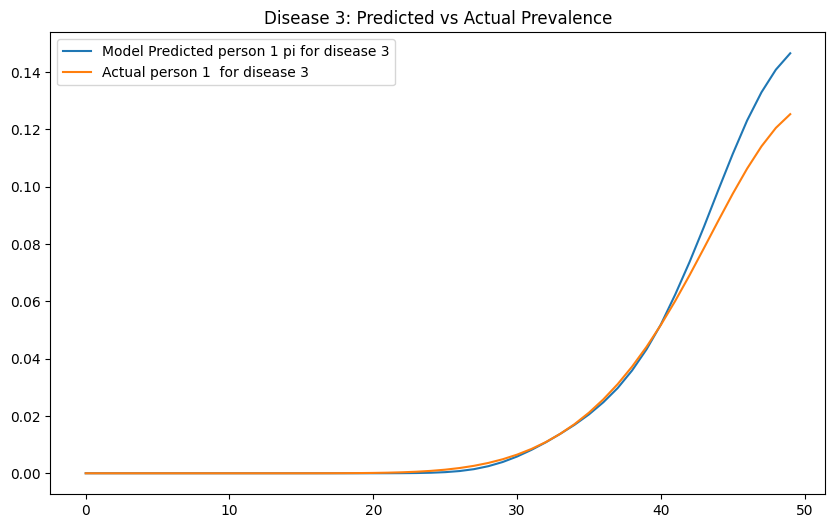

In [31]:
# Mean predicted probability for disease 3 over time
mean_pred_d3 = pi_pred[1, 3, :]  # Average across people

# Actual prevalence for disease 3 over time
real_prev_pi = data['pi'][1,3, :]  # Average across people

#real_prev_d3 = data['Y'][:, 3, :].mean(axis=0)  # Average across people

#real_prev_d3 = model.prevalence_t[3,:]  # Average across people

# Plot comparison
plt.figure(figsize=(10,6))
plt.plot(mean_pred_d3, label='Model Predicted person 1 pi for disease 3')
plt.plot(real_prev_pi, label='Actual person 1  for disease 3 ')
#plt.plot(real_prev_d3, label='Actual Incidence for disease 3')
plt.title('Disease 3: Predicted vs Actual Prevalence')
plt.legend()
plt.show()

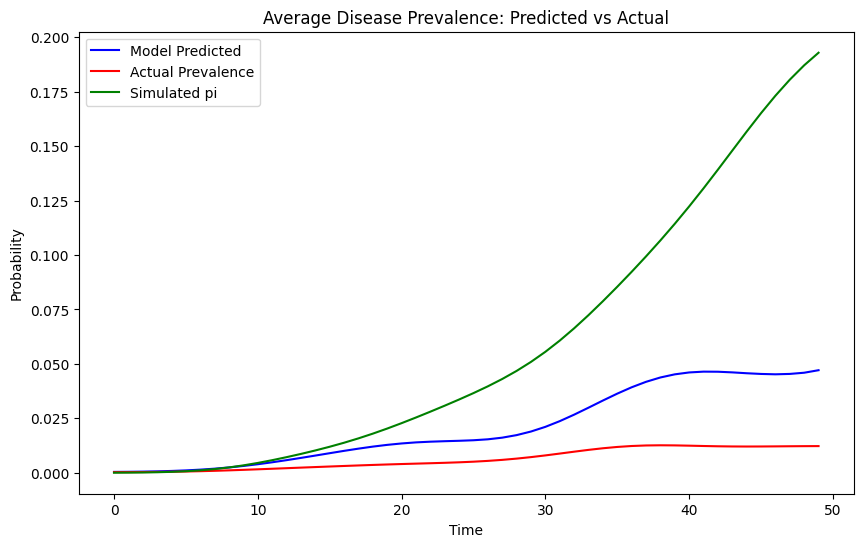

In [32]:
# Average over all diseases and all individuals
mean_pred_all = pi_pred.mean(axis=(0,1))  # Average across people and diseases
real_incidence_all = model.prevalence_t.mean(axis=0)  # Average across diseases
real_pi_all = data['pi'].mean(axis=(0,1)) # Average across diseases

plt.figure(figsize=(10,6))
plt.plot(mean_pred_all, 'b-', label='Model Predicted')
plt.plot(real_incidence_all, 'r-', label='Actual Prevalence') 
plt.plot(real_pi_all, 'g-', label='Simulated pi') 


plt.title('Average Disease Prevalence: Predicted vs Actual')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [33]:
model.kappa

Parameter containing:
tensor([4.1958], requires_grad=True)

In [34]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()
#observed_risk=mu_dt_flat
# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor
print(scale_factor)
print(np.mean(observed_risk))
print(np.mean(predicted_risk)) 
print(np.mean(calibrated_risk))

0.39541543
0.0083208
0.021043185
0.0083208


In [35]:
calibrated_risk.shape

(1000,)

In [36]:
scale_factor

np.float32(0.39541543)

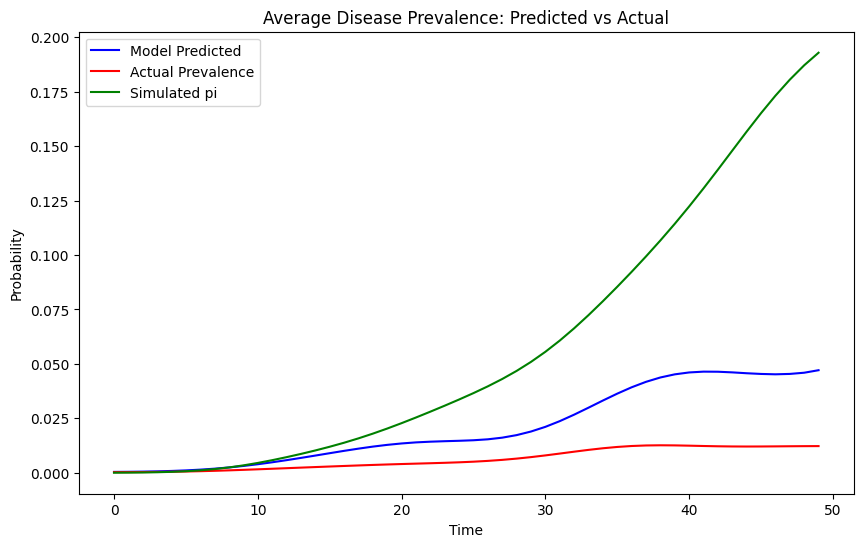

In [37]:
# Average over all diseases and all individuals
mean_pred_all = pi_pred.mean(axis=(0,1))
#mean_pred_all = pi_pred.mean(axis=(0,1))  # Average across people and diseases
real_incidence_all = model.prevalence_t.mean(axis=0)  # Average across diseases
#real_pi_all = calibrated_risk.mean(axis=(0,1)) # Average across diseases

plt.figure(figsize=(10,6))
plt.plot(mean_pred_all, 'b-', label='Model Predicted')
plt.plot(real_incidence_all, 'r-', label='Actual Prevalence') 
plt.plot(real_pi_all, 'g-', label='Simulated pi') 


plt.title('Average Disease Prevalence: Predicted vs Actual')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

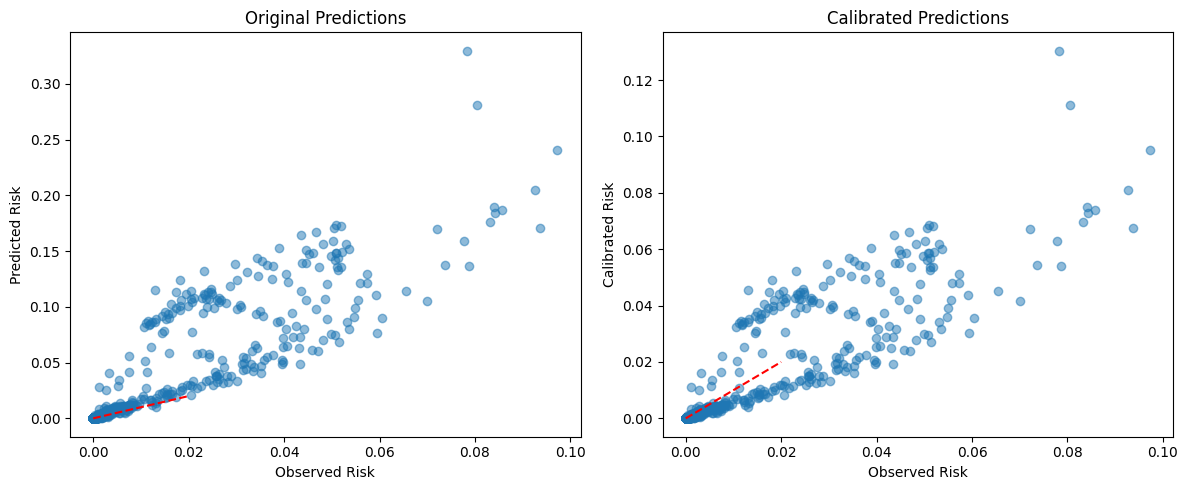

Mean observed risk: 0.008321
Mean predicted risk (original): 0.021043
Mean predicted risk (calibrated): 0.008321
Calibration scale factor: 0.395


In [38]:

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


In [39]:
def plot_hazard_comparison(Y, pi_pred, true_pi, calibration_factor):
    N, D, T = Y.shape
    
    # Create at_risk mask
    at_risk = np.ones_like(Y, dtype=bool)
    for n in range(N):
        for d in range(D):
            event_times = np.where(Y[n,d,:])[0]
            if len(event_times) > 0:
                at_risk[n,d,(event_times[0]+1):] = False
    
    # Apply calibration to predictions
    calibrated_pred = pi_pred * calibration_factor
    
    # Calculate means for at-risk only
    mean_pred = []
    mean_true = []
    mean_obs = []
    for t in range(T):
        mask_t = at_risk[:,:,t]
        if mask_t.sum() > 0:
            mean_pred.append(calibrated_pred[:,:,t][mask_t].mean())
            mean_true.append(true_pi[:,:,t][mask_t].mean())
            mean_obs.append(Y[:,:,t][mask_t].mean())
    
    plt.figure(figsize=(12,8))
    plt.plot(mean_pred, 'b-', label='Calibrated Model Prediction')
    plt.plot(mean_true, 'g--', label='True Hazard')
    plt.plot(mean_obs, 'r.', label='Observed Events')
    plt.title('Hazard Rates (At-Risk Individuals)')
    plt.xlabel('Time')
    plt.ylabel('Hazard')
    plt.legend()
    plt.show()

In [40]:
def calculate_calibration_factor(Y, pi_pred, true_pi):
    """
    Calculate calibration factor comparing predictions to true hazards
    Only using at-risk times
    """
    # Create at_risk mask
    N, D, T = Y.shape
    at_risk = np.ones_like(Y, dtype=bool)
    for n in range(N):
        for d in range(D):
            event_times = np.where(Y[n,d,:])[0]
            if len(event_times) > 0:
                at_risk[n,d,(event_times[0]+1):] = False
    
    # Get valid predictions and true values
    valid_pred = pi_pred[at_risk]
    valid_true = true_pi[at_risk]
    
    # Calculate calibration factor
    calibration_factor = valid_true.mean() / valid_pred.mean()
    
    print(f"Mean predicted: {valid_pred.mean():.6f}")
    print(f"Mean true: {valid_true.mean():.6f}")
    print(f"Calibration factor: {calibration_factor:.4f}")
    
    return calibration_factor

In [43]:
calculate_calibration_factor(Y, pi_pred, data['pi'])

Mean predicted: 0.009409
Mean true: 0.009513
Calibration factor: 1.0111


np.float64(1.0110507150209007)

In [90]:
plot_hazard_comparison(data['Y'], pi_pred, data['pi'],1)

NameError: name 'plot_hazard_comparison' is not defined

In [45]:
def calculate_fair_calibration_factor(Y, pi_pred):
    N, D, T = Y.shape
    
    # Create at_risk mask
    at_risk = np.ones_like(Y, dtype=bool)
    for n in range(N):
        for d in range(D):
            event_times = np.where(Y[n,d,:])[0]
            if len(event_times) > 0:
                at_risk[n,d,(event_times[0]+1):] = False
    
    # Calculate ratio of observed events to predictions for at-risk individuals
    total_observed = 0
    total_predicted = 0
    
    for t in range(T):
        mask_t = at_risk[:,:,t]
        if mask_t.sum() > 0:
            total_observed += Y[:,:,t][mask_t].sum()
            total_predicted += pi_pred[:,:,t][mask_t].sum()
    
    return total_observed / total_predicted if total_predicted > 0 else 1.0

cf=calculate_fair_calibration_factor(Y, pi_pred)

In [48]:
cf

np.float32(1.0107169)

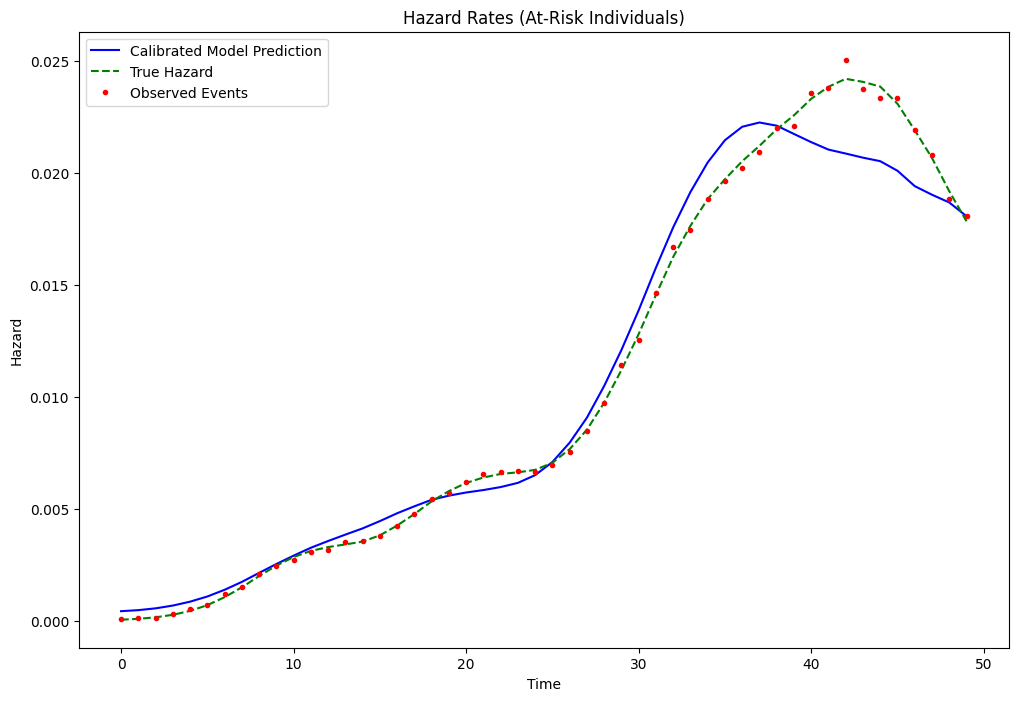

In [47]:
def plot_hazard_comparison(Y, pi_pred, true_pi, calibration_factor):
    N, D, T = Y.shape
    
    # Create at_risk mask
    at_risk = np.ones_like(Y, dtype=bool)
    for n in range(N):
        for d in range(D):
            event_times = np.where(Y[n,d,:])[0]
            if len(event_times) > 0:
                at_risk[n,d,(event_times[0]+1):] = False
    
    # Apply calibration to predictions
    calibrated_pred = pi_pred * calibration_factor

    # Calculate means for at-risk only
    mean_pred = []
    mean_true = []
    mean_obs = []
    for t in range(T):
        mask_t = at_risk[:,:,t]
        if mask_t.sum() > 0:
            mean_pred.append(calibrated_pred[:,:,t][mask_t].mean())
            mean_true.append(true_pi[:,:,t][mask_t].mean())
            mean_obs.append(Y[:,:,t][mask_t].mean())
    
    plt.figure(figsize=(12,8))
    plt.plot(mean_pred, 'b-', label='Calibrated Model Prediction')
    plt.plot(mean_true, 'g--', label='True Hazard')
    #plt.plot(real_incidence_all, 'r-', label='Actual Observed Incidence') 
    plt.plot(mean_obs, 'r.', label='Observed Events')
    plt.title('Hazard Rates (At-Risk Individuals)')
    plt.xlabel('Time')
    plt.ylabel('Hazard')
    plt.legend()
    
    plt.savefig('hazard_rates_kappa1.pdf', bbox_inches='tight', dpi=300)
    plt.show()
plot_hazard_comparison(Y, pi_pred, data['pi'],cf )
